# Dependencias

In [ ]:
 #BreakoutV4 and DQN dependencies
!pip install tensorflow==1.13.2 > /dev/null 2>&1; echo "tensorflow installed."
!pip install "gym==0.19.0" > /dev/null 2>&1; echo "gym installed."
!pip install autorom > /dev/null 2>&1; echo "autorom installed."
!pip install gym[accept-rom-license] stable_baselines[mpi] > /dev/null 2>&1; echo "gym license installed."
!pip install mushroom-rl==1.7.2 > /dev/null 2>&1; echo "mushroom rl installed"

# Display Dependencies
!pip install piglet pyvirtualdisplay > /dev/null 2>&1; echo "piglet installed."

In [ ]:
from typing import Optional, List, Tuple
import numpy as np
# import tensorflow as tf
# from tensorflow import keras

from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines import DQN

import gym

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
# from tensorflow.keras.layers import MaxPooling2D
import math
import random

# Deep Q Learning Approach

In [ ]:
env = gym.make('BreakoutNoFrameskip-v4')

model = None
try:
  model = DQN.load("breakout_v4")
  model.set_env(env)
except ValueError: # NOT LEARNING WTF
  model = DQN('LnCnnPolicy', env, prioritized_replay=True, verbose=1)
  model.learn(total_timesteps=15_000, log_interval=1)
  model.save("breakout_v4")

# Evaluate the agent
#mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)

# Enjoy trained agent
env.reset()
obs, _, _, _ = env.step(1)
screen = plt.imshow(env.render('rgb_array'))
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    screen.set_data(env.render(mode='rgb_array'))
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)

# Temporal Difference Learning Approach



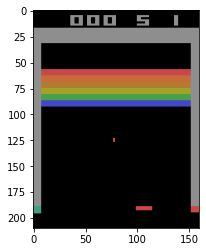

In [ ]:
env = gym.make('Breakout-v4')
env.reset()
prev_obs = None
obs, rewards, dones, info = env.step(1)
plt.imshow(obs)

In [ ]:
Position = Tuple[int, int]
BALL_COLOR = (200, 72, 72)
GAME_TOP_SECTION = [(8, 152), (32, 57)]
BLOCKS_RANGE = [(8, 152), (57, 93)]
BALL_SIGHT_RANGE = [(8, 152), (93, 189)]
BALL_SIGHT_OUT_RANGE = [(8, 152), (193, 198)]
BOARD_RANGE = [(8, 152), (190, 193)]
BOARD_DIM = (16, 3)
BALL_DIM = (2, 4)
BLOCK_DIM = (8, 6)
BALL_DIRECTIONS = ["Up or Not Moving", "Down Left", "Down Center", "Down Right"]

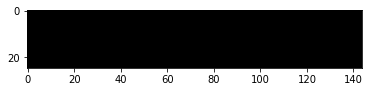

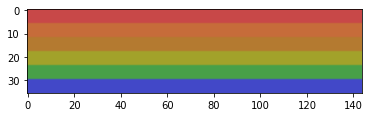

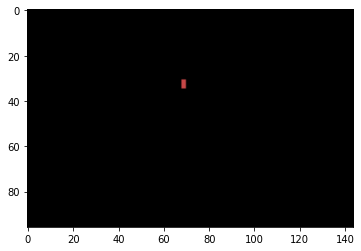

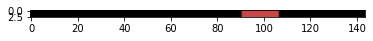

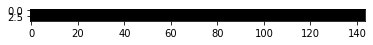

In [ ]:
plt.figure(); plt.imshow(obs[GAME_TOP_SECTION[1][0]:GAME_TOP_SECTION[1][1], GAME_TOP_SECTION[0][0]:GAME_TOP_SECTION[0][1]])
plt.figure(); plt.imshow(obs[BLOCKS_RANGE[1][0]:BLOCKS_RANGE[1][1], BLOCKS_RANGE[0][0]:BLOCKS_RANGE[0][1]])
plt.figure(); plt.imshow(obs[BALL_SIGHT_RANGE[1][0]:BALL_SIGHT_RANGE[1][1], BALL_SIGHT_RANGE[0][0]:BALL_SIGHT_RANGE[0][1]])
plt.figure(); plt.imshow(obs[BOARD_RANGE[1][0]:BOARD_RANGE[1][1], BOARD_RANGE[0][0]:BOARD_RANGE[0][1]])
plt.figure(); plt.imshow(obs[BALL_SIGHT_OUT_RANGE[1][0]: BALL_SIGHT_OUT_RANGE[1][1], BALL_SIGHT_OUT_RANGE[0][0]: BALL_SIGHT_OUT_RANGE[0][1]])

In [ ]:
def board_position(obs, minified = False) -> Position:
  """
  minified -> (centroid x-axis // 6, 0)
  unminified -> Returns board position. (centroid x-axis, upper bound y-axis)

  Minified No. Variations: 144 / 6 = 24
  Unminified No. Variations: 144
  """
  x = BOARD_RANGE[0]
  y = (BOARD_RANGE[1][0], BOARD_RANGE[1][0] + 1) 
  row = obs[y[0]: y[1], x[0]: x[1], 0]
  left_bound = int(row.argmax()) 
  
  # if left bound is from ball, begin from end
  if int(row[:, left_bound + BALL_DIM[0]: left_bound + BALL_DIM[0] + 1]) == 0:
    left_bound = row.shape[1] - int(np.flip(row).argmax()) - BOARD_DIM[0]

  if minified:
    position = ((left_bound + BOARD_DIM[0] // 2) // 6, 0)
  else:
    position = (
        left_bound + BOARD_DIM[0] // 2 + BOARD_RANGE[0][0],
        BOARD_RANGE[1][0],
    )

  return position


def ball_position(obs, minified = False) -> Optional[Position]:
  """
  Returns ball position in sight (0, 0). Else
    Unminfied -> (centroid x-axis, centrod y-axis)

  Minified No. Variations: ...
  Unminified No. Variations: ...
  """
  x = BALL_SIGHT_RANGE[0]
  y = BALL_SIGHT_RANGE[1]
  section = obs[y[0]: y[1], x[0]: x[1], 0]
  relative_position = np.unravel_index(
      np.argmax(section, axis=None),
      section.shape
  )
  if relative_position == (0, 0):
    return relative_position
  
  if minified:
    position = (
        (relative_position[1] + BALL_DIM[0] // 2) // 10, 
        (relative_position[1] + BALL_DIM[1] // 2) // 10, 
    )
  else:
    position = (
        relative_position[1] + BALL_SIGHT_RANGE[0][0] + BALL_DIM[0] // 2,
        relative_position[0] + BALL_SIGHT_RANGE[1][0] + BALL_DIM[1] // 2,
    )

  return position


def block_positions(obs) -> List[Position]:
  """
  Returns all block positions. [(centroid x-axis, centroid y-axis), ...]
  """
  block_positions = []
  for x in range(BLOCKS_RANGE[0][0], BLOCKS_RANGE[0][1], BLOCK_DIM[0]):
    for y in range(BLOCKS_RANGE[1][0], BLOCKS_RANGE[1][1], BLOCK_DIM[1]):
      block = obs[y: y + BLOCK_DIM[1], x: x + BLOCK_DIM[0], 0]
      if block.min() != 0:
        block_positions.append((
            x + BLOCK_DIM[0] // 2,
            y + BLOCK_DIM[1] // 2
        ))

  return block_positions


def block_matrix(obs, minified = False) -> List[Position]:
  """
  1 and 0 blocks matrix

  Minified No. Variations: (We cut the number of dimentions in half)
  Unminified No. Variations: ...
  """
  block_matrix = np.zeros((
      (BLOCKS_RANGE[1][1] - BLOCKS_RANGE[1][0]) // BLOCK_DIM[1],
      (BLOCKS_RANGE[0][1] - BLOCKS_RANGE[0][0]) // BLOCK_DIM[0]
  ))
  for x in range(BLOCKS_RANGE[0][0], BLOCKS_RANGE[0][1], BLOCK_DIM[0]):
    for y in range(BLOCKS_RANGE[1][0], BLOCKS_RANGE[1][1], BLOCK_DIM[1]):
      block = obs[y: y + BLOCK_DIM[1], x: x + BLOCK_DIM[0], 0]
      relative_x = (x - BLOCKS_RANGE[0][0]) // BLOCK_DIM[0]
      relative_y = (y - BLOCKS_RANGE[1][0]) // BLOCK_DIM[1]
      block_matrix[
        relative_y,
        relative_x
      ] = int(block.min() != 0)
  
  if minified:
    max_pool_2d = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")
    minified_shape = [dim // 2 for dim in block_matrix.shape]
    block_matrix = tf.reshape(block_matrix, [1, *block_matrix.shape, 1])
    block_matrix = max_pool_2d(block_matrix)
    block_matrix = tf.reshape(block_matrix, minified_shape)
    block_matrix = block_matrix.numpy()

  return np.uint32(block_matrix)


def ball_direction(obs, prev_obs) -> int:
  """
  Up in any direction or same Position or prev_obs is None -> 0
  Down Left Direction -> 1 [-0.0, -60)
  Down Center Direction -> 2 [-60, -90] or [60, 90]
  Down Right Direction -> 3 (0.0, 60)
  """
  if prev_obs is None:
    return 0

  ball_position_value = ball_position(obs)
  prev_ball_position_value = ball_position(prev_obs)

  if ball_position_value[1] < prev_ball_position_value[1] or ball_position_value == prev_ball_position_value:
    return 0
    
  relative_position = [
      ball_position_value[0] - prev_ball_position_value[0],
      ball_position_value[1] - prev_ball_position_value[1],
  ]

  if relative_position[0] == 0:
    return 2

  angle = math.degrees(math.atan(relative_position[1] / relative_position[0]))
  if 0 <= angle and angle < 60:
    return 3
  elif 0 <= angle and angle > -60:
    return 1
  return 2


def ball_hit_board(obs) -> bool:
  ball_position_value = ball_position(obs)
  board_position_value = board_position(obs)

  x_hit_boundary = (board_position_value[0] - BOARD_DIM[0] // 2, board_position_value[0] + BOARD_DIM[0] // 2)
  y_hit_boundary = (board_position_value[1] - 5, board_position_value[1])

  return (
      x_hit_boundary[0] <= ball_position_value[0] and
      x_hit_boundary[1] >= ball_position_value[0] and
      y_hit_boundary[0] <= ball_position_value[1] and
      y_hit_boundary[1] >= ball_position_value[1]
  )

def ball_hit_block(obs, prev_obs) -> bool:
  if prev_obs is None:
    return False
  block_matrix_value = block_matrix(obs)
  prev_block_matrix_value = block_matrix(prev_obs)
  return not np.array_equal(block_matrix_value, prev_block_matrix_value)

def ball_is_out(obs, prev_obs = None) -> bool:
  """
  Returns True if ball is not visible inside game. 
  Else returns False
  """
  if prev_obs is None:
    prev_obs_ball_is_out = True
  else:
    prev_obs_ball_is_out = ball_is_out(prev_obs)

  # Check if ball is inside of red block section.
  red_blocks = block_matrix(obs)[0]
  for empty_red_index in np.where(red_blocks == 0)[0]:
    x_start_empty_space = BLOCKS_RANGE[0][0] + BLOCK_DIM[0] * int(empty_red_index)
    x_end_empty_space = x_start_empty_space + BLOCK_DIM[0]
    empty_red_block = obs[BLOCKS_RANGE[1][0]:BLOCKS_RANGE[1][0] + BLOCK_DIM[1], x_start_empty_space:x_end_empty_space]
    # if empty space is not empty, it means that the ball is there.
    if empty_red_block.max() != 0:
      return False

  # Check if ball is inside of top, sight and remaining part of the block section
  block_section_minus_red = obs[BLOCKS_RANGE[1][0] + BLOCK_DIM[1]:BLOCKS_RANGE[1][1], BLOCKS_RANGE[0][0]:BLOCKS_RANGE[0][1]]
  top_section = obs[GAME_TOP_SECTION[1][0]:GAME_TOP_SECTION[1][1], GAME_TOP_SECTION[0][0]:GAME_TOP_SECTION[0][1]]
  sight_section = obs[BALL_SIGHT_RANGE[1][0]:BALL_SIGHT_RANGE[1][1], BALL_SIGHT_RANGE[0][0]:BALL_SIGHT_RANGE[0][1]]
  return (
      not np.all(block_section_minus_red == np.array(BALL_COLOR), axis=-1).max() and
      sight_section.max() == 0 and
      top_section.max() == 0 and
      prev_obs_ball_is_out
  )

In [ ]:
print("Board Position (not minified):", board_position(obs))
print("Ball Position (not minified):", ball_position(obs))
print("Block Positions(not minified) :", block_positions(obs))
print("Block Matrix (not minified):\n", block_matrix(obs))
print("=========================")
print("Board Position Minified:", board_position(obs, minified=True))
print("Ball Position Minified:", ball_position(obs, minified=True))
print("Block Matrix Minified:\n", block_matrix(obs, minified=True))
print("Direction: ", BALL_DIRECTIONS[ball_direction(obs, prev_obs)])
print("Ball Hit Board:", ball_hit_board(obs))
print("Ball Hit Block:", ball_hit_block(obs, prev_obs))
print("Ball is Out:", ball_is_out(obs))

Board Position (not minified): (107, 190)
Ball Position (not minified): (78, 125)
Block Positions(not minified) : [(12, 60), (12, 66), (12, 72), (12, 78), (12, 84), (12, 90), (20, 60), (20, 66), (20, 72), (20, 78), (20, 84), (20, 90), (28, 60), (28, 66), (28, 72), (28, 78), (28, 84), (28, 90), (36, 60), (36, 66), (36, 72), (36, 78), (36, 84), (36, 90), (44, 60), (44, 66), (44, 72), (44, 78), (44, 84), (44, 90), (52, 60), (52, 66), (52, 72), (52, 78), (52, 84), (52, 90), (60, 60), (60, 66), (60, 72), (60, 78), (60, 84), (60, 90), (68, 60), (68, 66), (68, 72), (68, 78), (68, 84), (68, 90), (76, 60), (76, 66), (76, 72), (76, 78), (76, 84), (76, 90), (84, 60), (84, 66), (84, 72), (84, 78), (84, 84), (84, 90), (92, 60), (92, 66), (92, 72), (92, 78), (92, 84), (92, 90), (100, 60), (100, 66), (100, 72), (100, 78), (100, 84), (100, 90), (108, 60), (108, 66), (108, 72), (108, 78), (108, 84), (108, 90), (116, 60), (116, 66), (116, 72), (116, 78), (116, 84), (116, 90), (124, 60), (124, 66), (124,

In [ ]:
from os import read, mkdir
import json
import random
from PIL import Image

#Clasico
class Agent:
  def __init__(self, epsilon = 0.1, alpha = 0.15, discount_factor = 0.2):
    self.policy = {}
    self.epsilon = epsilon
    self.alpha = alpha
    self.discount_factor = discount_factor
    self.actions = [0, 2, 3]
    self.actions_map = [
        "none",
        "none",
        "right",
        "left"
    ]
    self.prev_action = 0
    self.prev_state = None
    self.new_states_counter = 0
    
  def do(self, state: str, readable_state: dict) -> int:
    # intialize policy-state
    if state not in self.policy:
      self.init_policy_state(state)

    # define reward, best action given state and action
    reward = self.get_reward(readable_state)
    greedy_action = self.get_greedy_action(state)
    if random.randint(1, 100) <= (self.epsilon * 100):
      action = random.choice(self.actions)
    else:
      action = greedy_action
  
    # temporal difference update
    if self.prev_state is not None:
      temporal_difference_target = reward + self.discount_factor * self.policy[state][greedy_action]
      temporal_difference_delta = temporal_difference_target - self.policy[self.prev_state][self.prev_action]
      self.policy[self.prev_state][self.prev_action] += self.alpha * temporal_difference_delta

    # update prev state-action
    self.prev_state = state
    self.prev_action = action

    return action

  def load_policy(self, policy_filepath: str):
    openfile = open(policy_filepath, "r")
    json_payload = json.load(openfile)
    for state in json_payload["policy"]:
      self.policy[state] = {int(action): value for action, value in json_payload["policy"][state].items()}
    openfile.close()

  def write_policy(self, policy_filepath: str, metadata: dict = {}):
    metadata["number_of_new_states"] = self.new_states_counter
    metadata["number_of_total_states"] = len(self.policy)
    json_payload = {
        "policy": self.policy,
        "metadata": metadata
    }
    json_str = json.dumps(json_payload)
    openfile = open(policy_filepath, "w")
    openfile.write(json_str)
    openfile.close()
    self.new_states_counter = 0

  def get_greedy_action(self, state: str) -> int:
    max_value = -10e3
    best_action = None
    for action, action_value in self.policy[state].items():
      if max_value < action_value:
        best_action, max_value = action, action_value
    return int(best_action)

  def init_policy_state(self, state: str):
    self.policy[state] = {action: 0 for action in self.actions}
    self.new_states_counter += 1

  def get_reward(self, readable_state: dict) -> int:
    if readable_state["ball_hit_block"]:
      return 5
    if readable_state["ball_hit_board"]:
      return 2
    if readable_state["ball_is_out"]:
      return -5
    return 0


class BreakoutEnvironment:
  BALL_DIRECTIONS = ["Up or Not Moving", "Down Left", "Down Center", "Down Right"]

  def __init__(self):
    self.env = gym.make('Breakout-v4')
    self.reset()

  def reset(self):
    self.env.reset()
    self.cache_obs = None
    self.obs, self.dones, _, self.info = self.env.step(1)
    self.score = 0
    self.iteration = 0
    self.play_iteration = 0
    self.game_loading = False

  def generate_state(self, obs: np.array) -> str:
    block_matrix_value = block_matrix(obs, minified=True)
    block_matrix_value = block_matrix_value.reshape(
        (block_matrix_value.shape[0] * block_matrix_value.shape[1])
    ).tolist()
    ball_direction_value = ball_direction(obs, self.cache_obs)
    ball_hit_block_value = int(ball_hit_block(obs, self.cache_obs))
    ball_is_out_value = int(ball_is_out(obs, self.cache_obs))

    if ball_direction_value == 0:
      ball_position_value = -1,
      board_position_value = -1
      ball_hit_board_value = 0
    else:
      ball_position_value = ball_position(obs, minified=True)
      board_position_value = board_position(obs, minified=True)[0]
      ball_hit_board_value = int(ball_hit_board(obs))

    state = []
    state.extend(block_matrix_value)
    state.extend(ball_position_value)
    state.append(ball_direction_value)
    state.append(board_position_value)
    state.append(ball_hit_board_value)
    state.append(ball_hit_block_value)
    state.append(ball_is_out_value)

    return "".join([str(s) for s in state])

  def generate_state_readable(self, obs: np.array) -> dict:
    block_matrix_value = block_matrix(obs).tolist()
    raw_ball_direction_value = ball_direction(obs, self.cache_obs)
    ball_direction_value = self.BALL_DIRECTIONS[raw_ball_direction_value]

    ball_position_value = ball_position(obs)
    board_position_value = board_position(obs)
    ball_hit_board_value = ball_hit_board(obs)
    ball_hit_block_value = ball_hit_block(obs, self.cache_obs)
    ball_is_out_value = ball_is_out(obs, self.cache_obs)

    state = {
        "block_matrix": block_matrix_value,
        "ball_direction": ball_direction_value,
        "ball_position": ball_position_value,
        "board_position": board_position_value,
        "ball_hit_board": ball_hit_board_value,
        "ball_hit_block": ball_hit_block_value,
        "ball_is_out": ball_is_out_value,
    }

    return state

  def iterate(self, action: int):
    self.cache_obs = self.obs.copy()
    self.obs, _, _, self.info = self.env.step(action)
    self.iteration+=1
    self.play_iteration += not self.game_loading

  def run(self, agent: Agent, render: bool = True, save_render: bool = False, id: int = 0):
    # setup display and agent
    agent.prev_state = self.generate_state(self.obs)
    screen = plt.imshow(self.env.render('rgb_array'))

    # create folder for saving render images
    if save_render:
      mkdir(f"/content/agent_run/{id}")
    
    # Run one game
    while self.info["ale.lives"] > 0: 
      # read state
      raw_state = self.generate_state(self.obs)
      readable_state = self.generate_state_readable(self.obs) 

      # play breakout
      if self.game_loading:
        self.iterate(1)
        if not readable_state["ball_is_out"]:
          self.game_loading = False
      else:
        self.score += int(readable_state["ball_hit_block"])

        # run agent action
        action = agent.do(raw_state, readable_state)
        self.iterate(action)
        
        if readable_state["ball_is_out"]:
          self.game_loading = True

      # render game
      if render:
        screen.set_data(self.env.render(mode='rgb_array'))
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
      
      if save_render:
        img = Image.fromarray(self.obs, 'RGB')
        img.save(f'/content/agent_run/{id}/{self.iteration}.png')

  def train(self, agent: Agent, number_of_games: int, render: bool = False, save_render: bool = False, start_iteration: int = 1):
    for i in range(start_iteration, start_iteration + number_of_games + 1):
      print(f"Running Iteration `{i}`.")
      self.run(agent, render=render, id=i, save_render=True)
      agent.write_policy(f"/content/policy/{i}.json", metadata={
          "policy_name": f"policy_{i}.json",
          "policy_number": i,
          "played_iterations": self.play_iteration,
          "score": self.score,
      })
      print("Score:", self.score)
      print(f"Policy has been written `/content/policy_{i}.json`.")
      self.reset()

In [ ]:
breakout_environment = BreakoutEnvironment()
agent = Agent()
raw_state = breakout_environment.generate_state(breakout_environment.obs)
readable_state = breakout_environment.generate_state_readable(breakout_environment.obs)
print("Breakout State (Raw):", raw_state)
print("Breakout State (Readable):", readable_state)

NameError: ignored

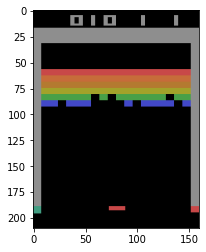

In [ ]:
breakout_environment = BreakoutEnvironment()
agent = Agent()
agent.load_policy("/content/501.json")
breakout_environment.run(agent, save_render=False)

Running Iteration `1`.
Score: 13
Policy has been written `/content/policy_1.json`.
Running Iteration `2`.
Score: 6
Policy has been written `/content/policy_2.json`.
Running Iteration `3`.
Score: 9
Policy has been written `/content/policy_3.json`.
Running Iteration `4`.
Score: 12
Policy has been written `/content/policy_4.json`.
Running Iteration `5`.
Score: 5
Policy has been written `/content/policy_5.json`.
Running Iteration `6`.
Score: 8
Policy has been written `/content/policy_6.json`.
Running Iteration `7`.
Score: 8
Policy has been written `/content/policy_7.json`.
Running Iteration `8`.
Score: 15
Policy has been written `/content/policy_8.json`.
Running Iteration `9`.
Score: 11
Policy has been written `/content/policy_9.json`.
Running Iteration `10`.
Score: 9
Policy has been written `/content/policy_10.json`.
Running Iteration `11`.
Score: 8
Policy has been written `/content/policy_11.json`.
Running Iteration `12`.
Score: 7
Policy has been written `/content/policy_12.json`.
Runnin

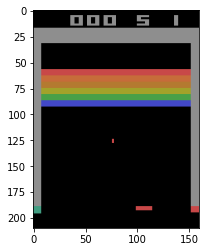

In [ ]:
!mkdir agent_run policy
breakout_environment = BreakoutEnvironment()
agent = Agent()
agent.load_policy("/content/501.json")
breakout_environment.train(agent, number_of_games=500, save_render=True)

{'block_matrix': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'ball_direction': 'Up or Not Moving',
 'ball_position': (77, 126),
 'board_position': (107, 190),
 'ball_hit_board': False,
 'ball_hit_block': False,
 'ball_is_out': False}

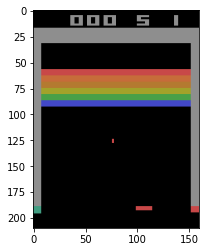

In [ ]:
plt.imshow(breakout_environment.env.render('rgb_array'))
breakout_environment.generate_state_readable(breakout_environment.obs)

In [ ]:
len(agent.policy)

8951

In [ ]:
agent.write_policy("/content/super_policy_100.json")

In [ ]:
# !zip -r data.zip agent_run policy
!du data_*.zip -h

	zip warning: name not matched: agent_run
	zip warning: name not matched: policy

zip error: Nothing to do! (try: zip -r data.zip . -i agent_run policy)
du: cannot access 'data_7.zip': No such file or directory


In [ ]:
!rm -rf /content/agent_run/*
!rm /content/policy/*

In [ ]:
!zip -r data_9.zip agent_run policy

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  adding: agent_run/335/224.png (deflated 36%)
  adding: agent_run/335/406.png (deflated 35%)
  adding: agent_run/335/510.png (deflated 38%)
  adding: agent_run/335/560.png (deflated 36%)
  adding: agent_run/335/270.png (deflated 37%)
  adding: agent_run/335/689.png (deflated 38%)
  adding: agent_run/335/5.png (deflated 40%)
  adding: agent_run/335/260.png (deflated 37%)
  adding: agent_run/335/655.png (deflated 37%)
  adding: agent_run/335/463.png (deflated 38%)
  adding: agent_run/335/53.png (deflated 38%)
  adding: agent_run/335/164.png (deflated 36%)
  adding: agent_run/335/574.png (deflated 36%)
  adding: agent_run/335/47.png (deflated 38%)
  adding: agent_run/335/409.png (deflated 37%)
  adding: agent_run/335/627.png (deflated 37%)
  adding: agent_run/335/108.png (deflated 37%)
  adding: agent_run/335/66.png (deflated 39%)
  adding: agent_run/335/216.png (deflated 37%)
  adding: agent_run/335/310.png (deflated 37%